# MyNN Implementation for Tendril Classification

In [42]:
import mygrad as mg

from datasets import ToyData
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt


We've used a two-layer neural network to solve a classification problem on a toy data set: a spiral formation of 2D data points. In this notebook, we will rewrite our solution to take advantage of MyNN, our main neural network library. This will serve as a gentle introduction to the library, which will prove to be very useful in moving forward with neural networks. In fact, MyNN is similar in spirit to PyTorch, so the insight you gain using MyNN will be helpful in moving on to full-scale deep learning libraries.

As before, let's construct and visualize our dataset

In [87]:
# Constructing the spiral dataset and its labels.
num_tendrils = 12
spiral_data = ToyData(num_classes=num_tendrils)

xtrain, ytrain, xtest, ytest = spiral_data.load_data()

<IPython.core.display.Javascript object>


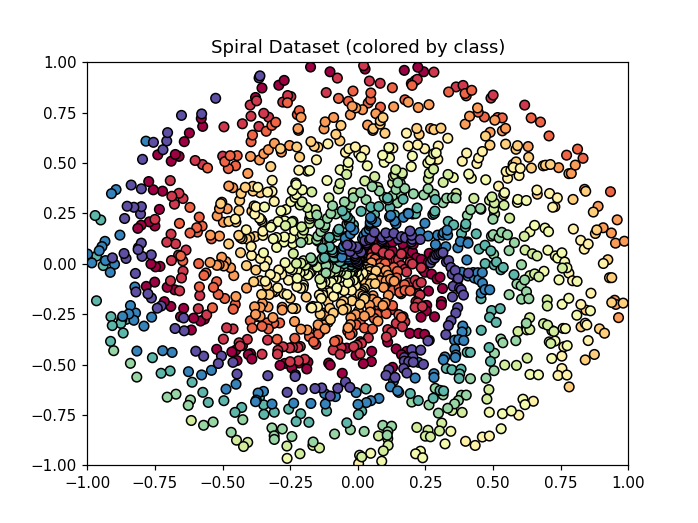

In [88]:
fig, ax = spiral_data.plot_spiraldata()

We'll reuse our accuracy function from the previous notebook that checked how accurate our model's predictions were.

In [80]:
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

## Introducing MyNN

Before, we had to construct the parameters of our neural network manually; recall that we created a `w`, `b`, and `v` ourselves with randomly initialized numpy arrays. Additionally, we had to manually perform gradient descent in order to update our parameters. One of the main advantages of using a neural network library such as MyNN is that this sort of low-level implementation is already taken care of. Essentially, neural network libraries will package up the general form of various functionality we may want to use such as gradient descent so that we can focus on algorithmic developments rather than reimplementing gradient descent every time we want to train a network.


### MyNN Layers
We were using fully-connected (dense) layers to solve our classification problem. These are packaged up conveniently inside MyNN in the `layers` module. Let's import the dense layer now:

In [89]:
from mynn.layers.dense import dense

MyNN allows us to conveniently create "layers" for our neural network - this is an object that initializes and stores the weights associated 

When we create a dense layer, we simply specify the desired shape of that layer. We can then call that layer like a function to pass data through it. As an example:

In [90]:

# This initializes a shape-(2, 3) Tensor, `weight`, and a shape-(3,) Tensor, `bias`
# and stores these tensors in this "dense layer". The weights are drawn from 
# default statistical distributions - we can also specify the distribution 
# that we want
dense_layer = dense(2, 3)

In [91]:
dense_layer.weight

Tensor([[0.27428449, 0.94543606, 0.34702711],
        [0.62846833, 0.77499014, 0.28770708]])

In [92]:
dense_layer.bias

Tensor([[0., 0., 0.]])

In [93]:
data = np.random.rand(4, 2)

# Calling `dense_layer(data)` multiplies the shape-(4, 2) matrix w/ our shape-(2, 3) 
# layer produces a shape-(4, 3) result
# This performs: `data @ w + b` 
dense_layer(data)

Tensor([[0.6069688 , 1.24798503, 0.460047  ],
        [0.46425608, 0.61731361, 0.22887927],
        [0.60254511, 1.19994434, 0.44248985],
        [0.04966082, 0.0983133 , 0.03625624]])

In [94]:
# You can easily access all of a layer's parameters, stored in a tuple,
# via <layer>.parameters
dense_layer.parameters

# this will make it easy for us to access all of our model's parameters
# for gradient descent

(Tensor([[0.27428449, 0.94543606, 0.34702711],
         [0.62846833, 0.77499014, 0.28770708]]), Tensor([[0., 0., 0.]]))

There are other types of layers (such as `conv`) packaged inside MyNN as well. 

You may have already thought to reuse some of the code that you wrote in the universal function approximator or in the Tendril classifier you wrote using plain MyGrad already; this is essentially all that MyNN is doing: packaging up useful chunks of code so that we can more easily, more quickly, and with fewer mistakes implement neural networks.

### Activation Functions

We'll also need to use our ReLU activation function. It and other activations are stored in `mynn.activations`. Let's import that now:

In [95]:
from mynn.activations.relu import relu

The final piece we need to create our model is a weight initializer. 

### Parameter-Initializers
In MyGrad, we used a he-normal to initialize our weights, and initialized our bias to 0. By default, MyNN will initialize a bias to zero, but we will need to pass in an initializer for the weight matrix (by default, MyNN will use a uniform distribution). 

The He-normal distribution and all other initializers are in `mynn.initializers`. There are several other initialization schemes defined in that module. Feel free to poke around and explore.

In [96]:
from mynn.initializers.he_normal import he_normal

## Creating a MyNN Model

Let's recreate the model that we developed before using MyNN this time!  

This `Model` class will maintain all of our layers and define how to propagate input through the network. By creating a model class, we can both organize the layers for our neural network as well as create a simple way for running a forward pass on our data through every layer. Creating a model object and passing in our data will give us the output of our model - it's that simple.

In `__init__(self)` we simply define our layers. In this case we have two dense layers as denoted by `dense1` and `dense2`.  To understand what happens in the dense layer try reading the documentation for `dense()`

In [158]:
class Model:
    def __init__(self, n, num_out):
        """This initializes all of the layers in our model, and sets them
        as attributes of the model.
        
        Parameters
        ----------
        n : int
            The size of our hidden layer
            
        num_out : int
            The size of the outpur layer (i.e. the number
            of tendrils)."""
        self.dense1 = dense(2, n, weight_initializer=he_normal)
        self.dense2 = dense(n, n * 2, weight_initializer=he_normal)
        self.dense3 = dense(n * 2, num_out, weight_initializer=he_normal)
        
    def __call__(self, x):
        '''Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(M, 2)
            A batch of data consisting of M pieces of data,
            each with a dimentionality of 2.
            
        Returns
        -------
        mygrad.Tensor, shape=(M, num_out)
            The model's prediction for each of the M pieces of data.
        '''
        
        # We pass our data through a dense layer, use the activation 
        # function relu and then pass it through our second dense layer
        # We don't have a second activation function because it happens
        # to be included in our loss function: softmax-crossentropy
        first = relu(self.dense1(x))
        second = relu(self.dense2(first))
        return self.dense3(second)
        
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model"""
        return self.dense1.parameters + self.dense2.parameters

In [159]:
model = Model(300, num_tendrils)

As before, we'll use the softmax cross-entropy loss provided by MyGrad. That being said, MyNN has some other loss functions are at `mynn.losses`

In [160]:
from mygrad.nnet.losses import softmax_crossentropy

Lastly, write our own gradient descent function. This is also taken care of in MyNN. As you know, gradient descent is an optimization method; thus, it is located inside `mynn.optimizers`.

In [161]:
from mynn.optimizers.sgd import SGD

When we construct an optimizer, we must pass it the parameters of our model and any additional hyperparameters (such as learning rate). After we have backpropagated our loss through our network by calling `loss.backward()`, we can call `step()` on the optimizer to perform a single step of the optimization procedure. In our case, the `step()` function will loop over all the parameters of our model and update them according to the gradient descent algorithm.

In [162]:
optim = SGD(model.parameters, learning_rate=0.1)

As before, we'll create a plot to see our loss and accuracy.

<IPython.core.display.Javascript object>


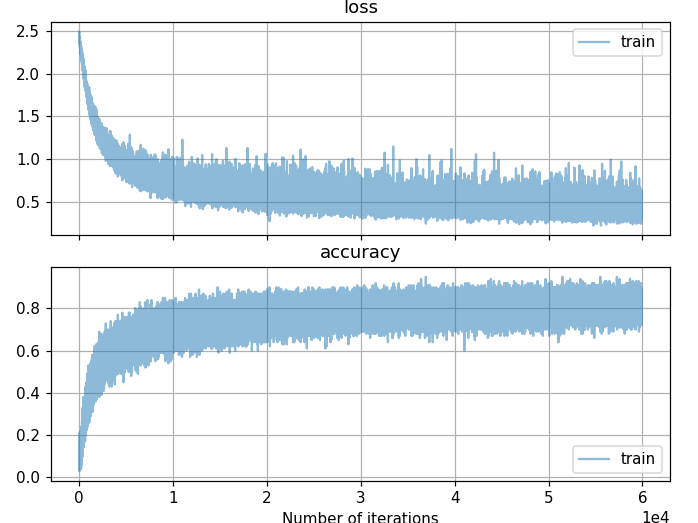

In [163]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

batch_size = 100

We can use the same exact training loop structure as before. However, MyNN will take care of most of this for us. We'l ljust need to:

- randomize our indices
- get a batch of training data
- call `model(batch)` on the data to get outputs
- get the truth
- compute the loss by calling `softmax_cross_entropy(predictions, truth)`
- backpropagate the loss
- call `optim.step()` to perform SGD
- null the gradients
- plot our training statistics

In [164]:
for epoch_cnt in range(5000):
    idxs = np.arange(len(xtrain))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(xtrain)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = xtrain[batch_indices]  # random batch of our training data

        # `model.__call__ is responsible for performing the "forward-pass"
        prediction = model(batch) 
        truth = ytrain[batch_indices]
        
        loss = softmax_crossentropy(prediction, truth)
        acc = accuracy(prediction, truth)
        
        # you still must compute all the gradients!
        loss.backward()
        
        # the optimizer is responsible for updating all of the parameters
        optim.step()
        loss.null_gradients()

        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)

As before, we can visualize our decision boundary.

0.78


<IPython.core.display.Javascript object>


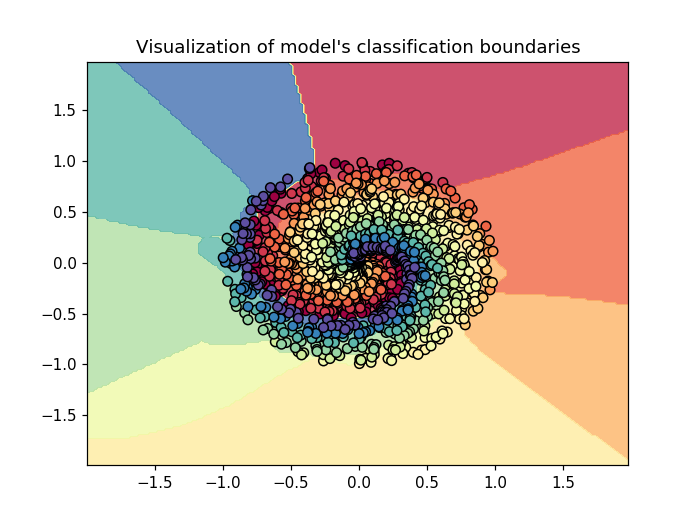

In [165]:
print(acc)
def dummy_function(x):
    from mygrad.nnet.activations import softmax
    return softmax(model(x)).data

fig, ax = spiral_data.visualize_model(dummy_function, entropy=False);

## Fitting a One-Layer Neural Network

Let's try to build up some more intuition for how our model classifies the tendrils. To do this, we will make our model even simpler - we will make a model with just *one* layer, instead of two. This model will not do a great job on classification, but it's operations will be easy to understand.

Create a single-layer neural network:

\begin{equation}
F(W, b; x) = softmax(Wx + b)
\end{equation}

and use softmax-crossentropy loss (so the softmax will actually by taken care of by the loss)

In [62]:
# Define your MyNN model-class; name is `SingleLayerModel`
class SingleLayerModel:
    def __init__(self, num_out=3):
        self.dense1 = dense(2, num_out, weight_initializer=he_normal)
    
    def __call__(self, x):
        '''Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(M, 2)
            A batch of data consisting of M pieces of data,
            each with a dimentionality of 2.
            
        Returns
        -------
        mygrad.Tensor, shape=(M, num_out)
            The model's prediction for each of the M pieces of data.
        '''
        
        # We pass our data through a dense layer, use the activation 
        # function relu and then pass it through our second dense layer
        # We don't have a second activation function because it happens
        # to be included in our loss function: softmax-crossentropy
        return self.dense1(x)

    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model"""
        return self.dense1.parameters

<IPython.core.display.Javascript object>


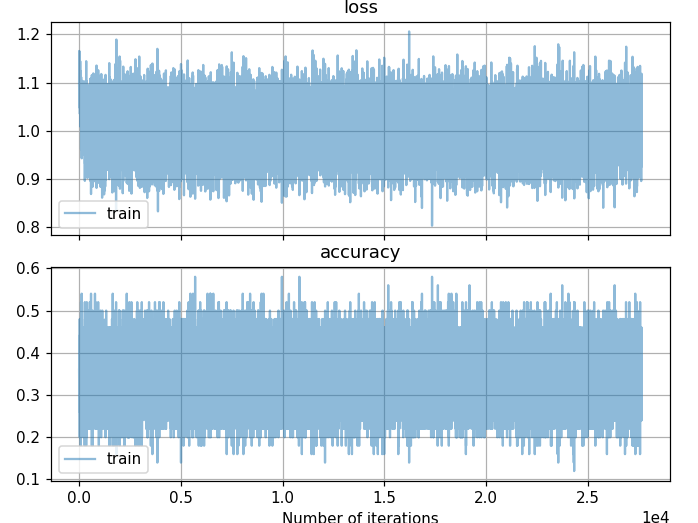

In [63]:
from mygrad.nnet.losses import softmax_crossentropy
from mynn.optimizers.sgd import SGD
from noggin import create_plot

model = SingleLayerModel(num_out=num_tendrils)
optim = SGD(model.parameters, learning_rate=0.1)


plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

batch_size = 50

Let's train this 1-layer model.

In [64]:
for epoch_cnt in range(5000):
    idxs = np.arange(len(xtrain))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(xtrain)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = xtrain[batch_indices]  # random batch of our training data

        # `model.__call__ is responsible for performing the "forward-pass"
        prediction = model(batch) 
        truth = ytrain[batch_indices]
        
        loss = softmax_crossentropy(prediction, truth)
        acc = accuracy(prediction, truth)
        
        # you still must compute all the gradients!
        loss.backward()
        
        # the optimizer is responsible for updating all of the parameters
        optim.step()
        loss.null_gradients()

        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)

### Understanding Your Results

<IPython.core.display.Javascript object>


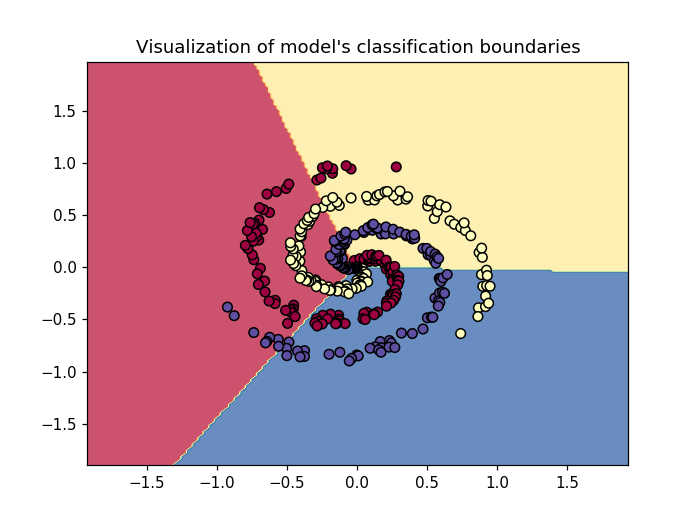

In [65]:
# Run this to visualize your results

def dummy_function(x):
    from mygrad.nnet.activations import softmax
    return softmax(model(x)).data

fig, ax = spiral_data.visualize_model(dummy_function, entropy=False);

Now print out the `weight` tensor of your single dense layer. What is its shape? Look back to the mathematical form of this neural network - what dot products are being performed by the matrix multiplication (are the rows of `weight` being used in the dot-product or the columns)?

On paper, sketch the classification visualization that you see above. **Draw the vectors stored in `weight` on top of this sketch**. 

Reflect on our discussion of the dot-product being a means of measuring how much two vectors *overlap*. What did this simple model learn and how is it doing its classification? 

*SOLUTION HERE*

In [77]:
print(model.dense1.weight.shape)

print(xtrain.shape)

(2, 1000)
(300, 2)
